In [275]:
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import TimeDistributed, Conv1D, Dense, MaxPooling1D, RepeatVector, LSTM, Flatten

In [276]:
# df = pd.read_csv('Data_Transformed_New.csv')
# df.set_index('Date', inplace=True)

df_transformed = pd.read_csv('Data_Transformed_New.csv')
df_original = pd.read_csv('Missing_dates_filled_sol.csv')
df_cpy = pd.merge(df_original, df_transformed, on='Date', how='inner')
df_cpy.rename(columns={'sumOfLights': 'sol_org'}, inplace=True)
df_cpy.set_index('Date', inplace=True)

df = df_cpy
df.drop(columns=['sol'], inplace=True)
df.head()

,sol_org,ele
Date,,
2012-04-01,1.280000e+06,2476
2012-04-02,1.120000e+06,2512
2012-04-03,1.010000e+06,2532
2012-04-04,8.726831e+05,2559
2012-04-05,9.060528e+05,2530


In [277]:
split_index = int(len(df)*0.8)
train, test = df[:split_index], df[split_index:]

In [278]:
scalers = {}

for i in train.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
    scalers['scaler'+i] = scaler

for i in test.columns:
    scaler = scalers['scaler'+i]
    test[i] = scaler.fit_transform(test[i].values.reshape(-1,1))

C:\Users\darsh\AppData\Local\Temp\ipykernel_23376\1665150634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_23376\1665150634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_23376\1665150634.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [279]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1

        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix,:], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [280]:
n_steps_in, n_steps_out = 360, 60

X_train, y_train = split_sequences(train.values, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test.values, n_steps_in, n_steps_out)

n_features, n_seq, n_steps_in = X_train.shape[2], 12, 30

X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps_in, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps_in, n_features))

In [281]:
X_train.shape

(3015, 12, 30, 2)

Epoch 1/100
95/95 [==============================] - 121s 1s/step - loss: 0.0829 - root_mean_squared_error: 0.2879
Epoch 2/100
95/95 [==============================] - 122s 1s/step - loss: 0.0132 - root_mean_squared_error: 0.1149
Epoch 3/100
95/95 [==============================] - 108s 1s/step - loss: 0.0106 - root_mean_squared_error: 0.1032
Epoch 4/100
95/95 [==============================] - 107s 1s/step - loss: 0.0093 - root_mean_squared_error: 0.0963
Epoch 5/100
95/95 [==============================] - 132s 1s/step - loss: 0.0084 - root_mean_squared_error: 0.0915
Epoch 6/100
95/95 [==============================] - 110s 1s/step - loss: 0.0076 - root_mean_squared_error: 0.0874
Epoch 7/100
95/95 [==============================] - 110s 1s/step - loss: 0.0070 - root_mean_squared_error: 0.0834
Epoch 8/100
95/95 [==============================] - 112s 1s/step - loss: 0.0063 - root_mean_squared_error: 0.0795
Epoch 9/100
95/95 [==============================] - 113s 1s/step - loss: 0.0058

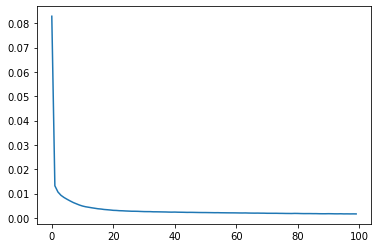

In [282]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(n_seq, n_steps_in, n_features))))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(Flatten())
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(200, activation='relu')))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

# print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=100)
plt.plot(history.history['loss'])
plt.show()

In [283]:
predictions = model.predict(X_test)

14/14 [==============================] - 6s 387ms/step


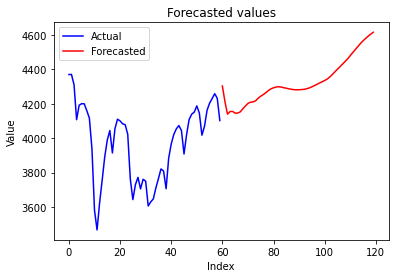

In [284]:
y_org = scalers['scalerele'].inverse_transform(y_test)
pred_org = scalers['scalerele'].inverse_transform(predictions[-1])

plt.plot(y_org[-1], label='Actual', color='blue')
end_index = len(y_org[-1])
plt.plot(range(end_index, end_index+len(pred_org)), pred_org, label='Forecasted', color='red')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Forecasted values')
plt.legend()

# Show plot
plt.show()

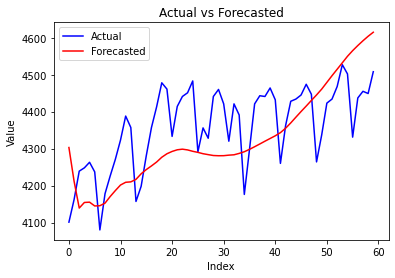

In [285]:
actual = [4101, 4162, 4239, 4248, 4263, 4237, 4080, 4178, 4226, 4271, 4323, 4388, 4357, 4157, 4198, 4281, 4357, 4413, 4478, 4461, 4333, 4414, 4441, 4451, 4483, 4291, 4356, 4328, 4441, 4460, 4421, 4320, 4421, 4391, 4176, 4297, 4421, 4443, 4441, 4464, 4432, 4260, 4362, 4428, 4434, 4445, 4474, 4447, 4264, 4337, 4423, 4434, 4468, 4527, 4502, 4331, 4437, 4455, 4449, 4508]

plt.plot(actual[:60], label='Actual', color='blue')
plt.plot(pred_org, label='Forecasted', color='red')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Forecasted')
plt.legend()

# Show plot
plt.show()

In [286]:
math.sqrt(mean_squared_error(actual[:60], pred_org))

114.11346820035146

In [245]:
# n_steps_in, n_steps_out = 360, 60

# X_train, y_train = split_sequences(train.values, n_steps_in, n_steps_out)
# X_test, y_test = split_sequences(test.values, n_steps_in, n_steps_out)

# n_features, n_seq, n_steps_in = X_train.shape[2], 12, 30

# print(X_train.shape)
# X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps_in, n_features))
# X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps_in, n_features))

n_steps_in, n_steps_out = 360, 60

X_train, y_train = split_sequences(train.values, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(test.values, n_steps_in, n_steps_out)

n_features, n_seq, n_steps_in = X_train.shape[2], 12, 30

X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps_in, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps_in, n_features))

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_88 (TimeDi  (None, None, 30, 64)     192       
 stributed)                                                      
                                                                 
 time_distributed_89 (TimeDi  (None, None, 15, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_90 (TimeDi  (None, None, 960)        0         
 stributed)                                                      
                                                                 
 lstm_23 (LSTM)              (None, 50)                202200    
                                                                 
 dense_43 (Dense)            (None, 60)                3060      
                                                     

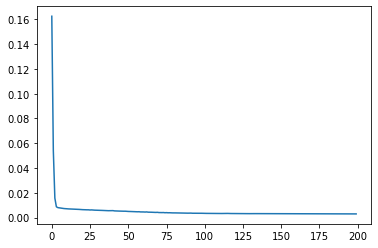

In [246]:
# input_seq = Input(shape=(n_seq, 1, n_steps_in, n_features), name='input_seq')
# conv_lstm = ConvLSTM2D(filters=128, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_in, n_features))(input_seq)
# flatten = Flatten()(conv_lstm)
# output = Dense(n_steps_out, name='output')(flatten)
# model = tf.keras.Model(inputs=input_seq, outputs=output)
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[RootMeanSquaredError()])
# print(model.summary())


# history = model.fit(X_train, y_train, epochs=70)
# plt.plot(history.history['loss'])
# plt.show()


model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),input_shape=(None, n_steps_in, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=200)
plt.plot(history.history['loss'])
plt.show()

In [247]:
predictions = model.predict(X_test)
print(predictions)

14/14 [==============================] - 1s 9ms/step
[[0.61928374 0.561463   0.5451766  ... 0.46912956 0.48630306 0.53566134]
 [0.6040824  0.55582225 0.5443699  ... 0.49084026 0.4975037  0.5452256 ]
 [0.56322944 0.5317123  0.53310394 ... 0.50204265 0.514703   0.54979205]
 ...
 [0.6423763  0.63688296 0.61353916 ... 0.38774318 0.38182077 0.45589775]
 [0.65448534 0.6408663  0.60648906 ... 0.38882628 0.39556137 0.4549076 ]
 [0.6461897  0.6342424  0.5921094  ... 0.40255082 0.4039488  0.46511388]]


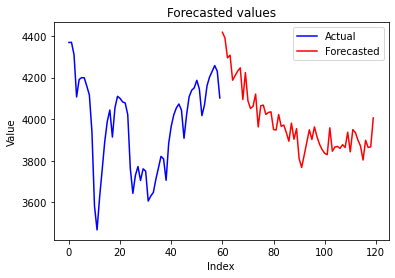

In [248]:
y_org = scalers['scalerele'].inverse_transform(y_test)
pred_org = scalers['scalerele'].inverse_transform(predictions)

plt.plot(y_org[-1], label='Actual', color='blue')
end_index = len(y_org[-1])
plt.plot(range(end_index, end_index+len(pred_org[-1])), pred_org[-1], label='Forecasted', color='red')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Forecasted values')
plt.legend()

# Show plot
plt.show()

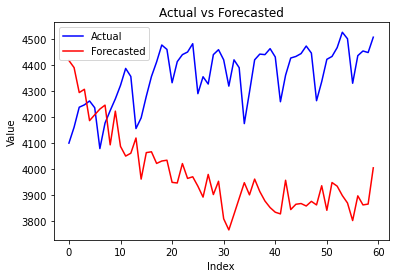

In [249]:
actual = [4101, 4162, 4239, 4248, 4263, 4237, 4080, 4178, 4226, 4271, 4323, 4388, 4357, 4157, 4198, 4281, 4357, 4413, 4478, 4461, 4333, 4414, 4441, 4451, 4483, 4291, 4356, 4328, 4441, 4460, 4421, 4320, 4421, 4391, 4176, 4297, 4421, 4443, 4441, 4464, 4432, 4260, 4362, 4428, 4434, 4445, 4474, 4447, 4264, 4337, 4423, 4434, 4468, 4527, 4502, 4331, 4437, 4455, 4449, 4508]
# result_list = [x - 200 for x in actual]

plt.plot(actual[:60], label='Actual', color='blue')
plt.plot(pred_org[-1], label='Forecasted', color='red')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Forecasted')
plt.legend()

# Show plot
plt.show()

In [250]:
math.sqrt(mean_squared_error(actual[:60], pred_org[-1]))

442.9797718698967